# Argentine Basin - Strong Currents Pull Down Subsurface Moorings
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on May 6, 2020. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download CTD and ADCP data from the Global Argentine Basin Flanking Subsurface Moorings using the Machine-to-Machine (M2M) interface, create quick plots, and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from geopy.distance import geodesic

## 1. Request Data from OOINet

**Global Argentine Basin Flanking Subsurface Mooring A (GA03FLMA)**

**Global Argentine Basin Flanking Subsurface Mooring B (GA03FLMB)**
* CTDs (deployed at 30m)
    * Instruments: GA03FLMA-RIM01-02-CTDMOG040, GA03FLMB-RIM01-02-CTDMOG060
    * Data stream: ctdmo_ghqr_instrument_recovered
    * Parameters: ctdmo_seawater_pressure, ctdmo_seawater_temperature, density
* ADCPs (upward looking, deployed at 500m)
    * Instruments: GA03FLMA-RIM01-02-ADCPSL003, GA03FLMB-RIM01-02-ADCPSL007
    * Data stream: adcp_velocity_earth
    * Parameter: eastward_seawater_velocity, bin_depths
* Time range: 2016-05-01 to 2016-07-15
* Delivery method: recovered_inst

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/extras'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for these instruments. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# FLMA_CTD_url = request_data('GA03FLMA-RIM01-02-CTDMOG040', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                             '2016-05-01T00:00:00.000Z', '2016-07-15T00:00:00.000Z')

# FLMA_ADCP_url = request_data('GA03FLMA-RIM01-02-ADCPSL003', 'recovered_inst', 'adcp_velocity_earth',
#                              '2016-05-01T00:00:00.000Z', '2016-07-15T00:00:00.000Z')

# FLMB_CTD_url = request_data('GA03FLMB-RIM01-02-CTDMOG060', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                             '2016-05-01T00:00:00.000Z', '2016-07-15T00:00:00.000Z')

# FLMB_ADCP_url = request_data('GA03FLMB-RIM01-02-ADCPSL007', 'recovered_inst', 'adcp_velocity_earth',
#                              '2016-05-01T00:00:00.000Z', '2016-07-15T00:00:00.000Z')

# print('FLMA_CTD_url = %s' %FLMA_CTD_url)
# print('FLMA_ADCP_url = %s' %FLMA_ADCP_url)
# print('FLMB_CTD_url = %s' %FLMB_CTD_url)
# print('FLMB_ADCP_url = %s' %FLMB_ADCP_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
FLMA_CTD_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200506T135115217Z-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
FLMA_ADCP_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200506T135115543Z-GA03FLMA-RIM01-02-ADCPSL003-recovered_inst-adcp_velocity_earth/catalog.html'
FLMB_CTD_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200506T135117016Z-GA03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
FLMB_ADCP_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200506T135117295Z-GA03FLMB-RIM01-02-ADCPSL007-recovered_inst-adcp_velocity_earth/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        if 'ADCPS' in ds.sensor:
            # determine the number of bins to which time stamps need to be applied
            varlength = len(ds['bin_depths'].values.T)
            data_dict['time'] = np.append(data_dict['time'], np.repeat(ds['time'].values, varlength, axis=0))
        else:
            data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            if 'ADCPS' in ds.sensor:
                data_dict[var] = np.append(data_dict[var], ds[var].values.flatten())
            else:
                data_dict[var] = np.append(data_dict[var], ds[var].values)
            try:
                units = ds[var].units
                if units not in unit_dict[var]:
                    unit_dict[var].append(units)
            except AttributeError:
                continue

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

## Flanking Mooring A
Now we can specify the variables we want and get the data. Let's first look at Flanking Mooring A.

In [7]:
# Specify the variables of interest and get the data
CTDvars = ['ctdmo_seawater_pressure', 'ctdmo_seawater_temperature', 'density']
ADCPvars = ['bin_depths', 'eastward_seawater_velocity', 'percent_bad_beams']

FLMA_CTD_data, FLMA_CTD_units = get_data(FLMA_CTD_url, CTDvars)
FLMA_ADCP_data, FLMA_ADCP_units = get_data(FLMA_ADCP_url, ADCPvars)

# make sure the ADCP data are sorted by time and bin depth
FLMA_ADCP_data.sort_values(by=['time', 'bin_depths'], inplace=True)

print(FLMA_CTD_units)
print(FLMA_ADCP_units)

Appending data from files
Appending data from files
{'ctdmo_seawater_pressure': ['dbar'], 'ctdmo_seawater_temperature': ['ºC'], 'density': ['kg m-3']}
{'bin_depths': ['m'], 'eastward_seawater_velocity': ['m s-1'], 'percent_bad_beams': ['percent']}


In [8]:
# print out the first few lines of each dataset
FLMA_CTD_data.head(10)

,time,ctdmo_seawater_pressure,ctdmo_seawater_temperature,density
0,2016-05-01 00:00:01,49.355187,13.993378,1025.935792
1,2016-05-01 00:15:01,49.612316,13.986935,1025.935107
2,2016-05-01 00:30:01,49.858190,13.987675,1025.934942
3,2016-05-01 00:45:01,49.675753,13.990564,1025.933181
4,2016-05-01 01:00:01,49.351208,13.994267,1025.932677
5,2016-05-01 01:15:01,49.441572,13.995379,1025.935334
6,2016-05-01 01:30:01,49.341529,13.996490,1025.933215
7,2016-05-01 01:45:01,49.163473,14.002862,1025.934338
8,2016-05-01 02:00:01,49.003621,14.002418,1025.934170
9,2016-05-01 02:15:01,48.571159,13.999528,1025.934139


In [9]:
FLMA_ADCP_data.head(10)

,time,bin_depths,eastward_seawater_velocity,percent_bad_beams
97734,2016-05-01,-37.173305,NaN,100.0
97733,2016-05-01,-27.173305,NaN,100.0
97732,2016-05-01,-17.173305,1.338562,59.0
97731,2016-05-01,-7.173305,1.759749,51.0
97730,2016-05-01,2.826695,1.367891,48.0
97729,2016-05-01,12.826695,0.883623,70.0
97728,2016-05-01,22.826695,0.435604,70.0
97727,2016-05-01,32.826695,-0.102718,55.0
97726,2016-05-01,42.826695,-0.228107,0.0
97725,2016-05-01,52.826695,-0.277493,0.0


Let's do a little bit of clean-up with the ADCP data - we'll only keep rows of the dataframe where bin depths are positive numbers and where percent bad beams is less than than 25%.

In [10]:
FLMA_ADCP_data = FLMA_ADCP_data[(FLMA_ADCP_data['bin_depths'] > 0) & (FLMA_ADCP_data['percent_bad_beams'] < 25)]
FLMA_ADCP_data.head()

,time,bin_depths,eastward_seawater_velocity,percent_bad_beams
97726,2016-05-01,42.826695,-0.228107,0.0
97725,2016-05-01,52.826695,-0.277493,0.0
97724,2016-05-01,62.826695,-0.276620,0.0
97723,2016-05-01,72.826695,-0.226118,0.0
97722,2016-05-01,82.826695,-0.175382,0.0


Let's make some quick timeseries plots.

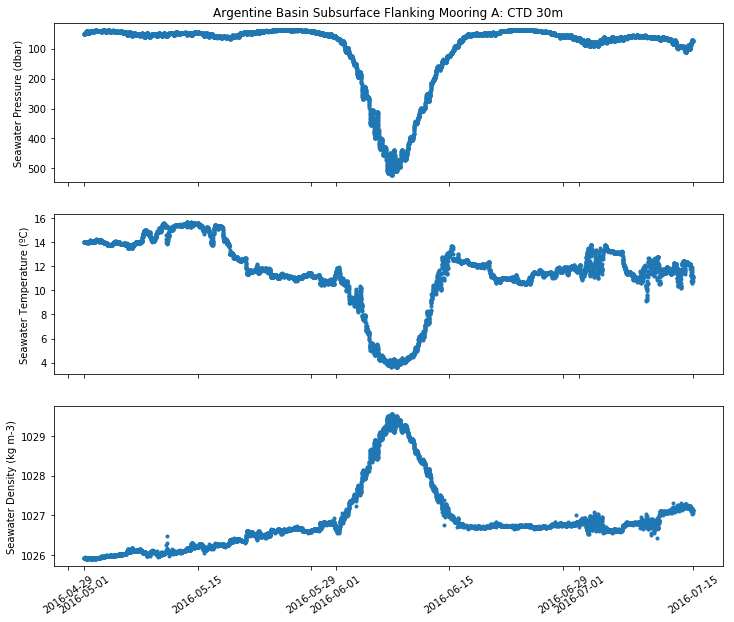

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 10))
ax1.plot(FLMA_CTD_data['time'], FLMA_CTD_data['ctdmo_seawater_pressure'], '.')
ax1.invert_yaxis()
ax2.plot(FLMA_CTD_data['time'], FLMA_CTD_data['ctdmo_seawater_temperature'], '.')
ax3.plot(FLMA_CTD_data['time'], FLMA_CTD_data['density'], '.')
ax1.set_title('Argentine Basin Subsurface Flanking Mooring A: CTD 30m')
ax1.set_ylabel('Seawater Pressure ({})'.format(FLMA_CTD_units['ctdmo_seawater_pressure'][0]))
ax2.set_ylabel('Seawater Temperature ({})'.format(FLMA_CTD_units['ctdmo_seawater_temperature'][0]))
ax3.set_ylabel('Seawater Density ({})'.format(FLMA_CTD_units['density'][0]))

# rotate x tick labels
plt.xticks(rotation=35);

The pressure recorded by this instrument increased by about 500 dbar in June 2016, which seems unreasonable. However, seawater density increased and seawater temperature decreased, which is consistent with the instrument descending in the water column. Let's look at the annotations in the system for this instrument to see if the operators noted anything for this time period via the annotation API. Note: you can also download the annotations.json included with your data download in the THREDDS server.

In [12]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
    'beginDT': int(dt.date(2016, 5, 1).strftime('%s'))*1000,
    'endDT': int(dt.date(2016, 7, 15).strftime('%s'))*1000,
    'refdes': 'GA03FLMA-RIM01-02-CTDMOG040',
}

r = requests.get(ANNO_API, params=params, auth=(API_USERNAME, API_TOKEN))
anno_data = r.json()

anno_df = pd.DataFrame()  # Setup empty array
for ad in anno_data:
    anno_df = anno_df.append({
        'annotation': ad['annotation'],
        'start': dt.datetime.utcfromtimestamp(ad['beginDT']/1000),
        'stop': dt.datetime.utcfromtimestamp(ad['endDT']/1000),
        'site': ad['subsite'],
        'node': ad['node'],
        'sensor': ad['sensor'],
        'id': ad['id']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1)  # Show the full annotation text
anno_df

,annotation,id,node,sensor,site,start,stop
0,Deployments 2 and 3: Data were not transmitted via satellite telemetry.,375.0,None,None,GA03FLMA,2015-11-25 19:21:00,2018-01-09 12:15:00
1,Deployment 2: Mooring was blown down by ~500m. Corresponds to the presence of eddies in the region based on altimetry imagery.,661.0,None,None,GA03FLMA,2016-06-01 00:00:00,2016-06-20 00:00:00


The second annotation describes what we see in the data - the mooring was blown down about 500m by very strong currents.

Let's take a look at the ADCP data.

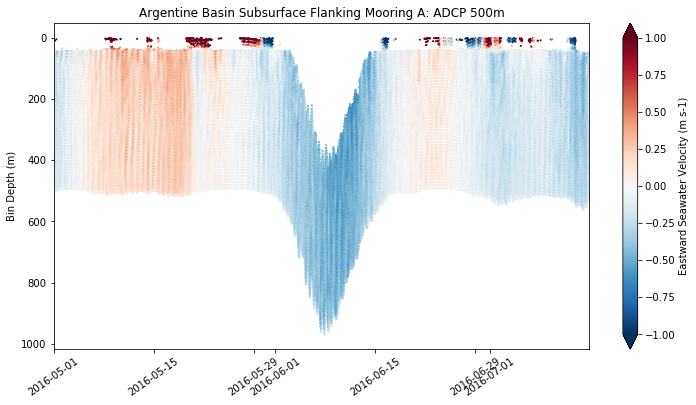

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
pcm = ax.scatter(np.array(FLMA_ADCP_data['time']), FLMA_ADCP_data['bin_depths'], 
                 c=FLMA_ADCP_data['eastward_seawater_velocity'], cmap='RdBu_r', s=1,
                 vmin=-1, vmax=1)
ax.invert_yaxis()
clabel = 'Eastward Seawater Velocity ({})'.format(FLMA_ADCP_units['eastward_seawater_velocity'][0])
bar = fig.colorbar(pcm, ax=ax, label=clabel, extend='both')
ax.set_ylabel('Bin Depth ({})'.format(FLMA_ADCP_units['bin_depths'][0]))
ax.set_title('Argentine Basin Subsurface Flanking Mooring A: ADCP 500m')

# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(FLMA_ADCP_data['time']), np.nanmax(FLMA_ADCP_data['time'])])

# rotate x tick labels
plt.xticks(rotation=35);

We can clearly see the same change in pressure in the ADCP data in June, which corresponds to a strong westward current. However, there is still some noise in the data farthest away from the instrumet near the surface, which is common for ADCP data. So let's just remove all of the data at <30m depth to further clean the dataset, then re-plot.

In [14]:
FLMA_ADCP_data = FLMA_ADCP_data[FLMA_ADCP_data['bin_depths'] > 30]

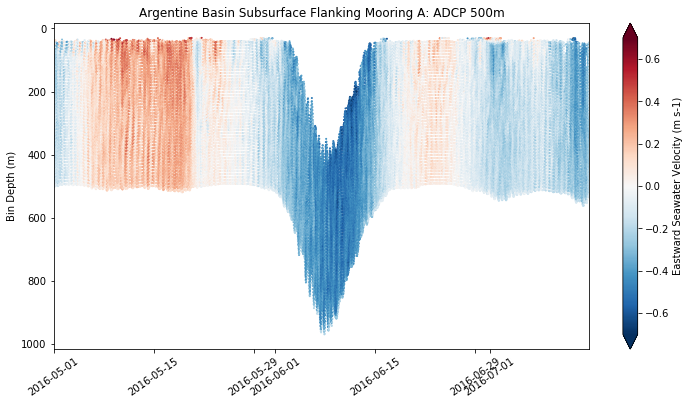

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
pcm = ax.scatter(np.array(FLMA_ADCP_data['time']), FLMA_ADCP_data['bin_depths'], 
                 c=FLMA_ADCP_data['eastward_seawater_velocity'], cmap='RdBu_r', s=1,
                 vmin=-0.7, vmax=0.7)
ax.invert_yaxis()
clabel = 'Eastward Seawater Velocity ({})'.format(FLMA_ADCP_units['eastward_seawater_velocity'][0])
bar = fig.colorbar(pcm, ax=ax, label=clabel, extend='both')
ax.set_ylabel('Bin Depth ({})'.format(FLMA_ADCP_units['bin_depths'][0]))
ax.set_title('Argentine Basin Subsurface Flanking Mooring A: ADCP 500m')

# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(FLMA_ADCP_data['time']), np.nanmax(FLMA_ADCP_data['time'])])

# rotate x tick labels
plt.xticks(rotation=35);

## Flanking Mooring B
Let's look at the data from Flanking Mooring B to see if the strong currents were localized only to the region near Flanking Mooring A, or if the strong currents affected the entire array. First, we'll grab the data from the instruments on Flanking Mooring B, then calculate how far the two moorings are from each other.

In [16]:
FLMB_CTD_data, FLMB_CTD_units = get_data(FLMB_CTD_url, CTDvars)
FLMB_ADCP_data, FLMB_ADCP_units = get_data(FLMB_ADCP_url, ADCPvars)

# make sure the ADCP data are sorted by time and bin depth
FLMB_ADCP_data.sort_values(by=['time', 'bin_depths'], inplace=True)

print(FLMB_CTD_units)
print(FLMB_ADCP_units)

Appending data from files
Appending data from files
{'ctdmo_seawater_pressure': ['dbar'], 'ctdmo_seawater_temperature': ['ºC'], 'density': ['kg m-3']}
{'bin_depths': ['m'], 'eastward_seawater_velocity': ['m s-1'], 'percent_bad_beams': ['percent']}


Now that we have the data from both moorings, let's get the latitude and longitude of each mooring from the CTD datasets - the function below will open one of the datasets in the THREDDS catalog and grab the mooring location from the global attributes.

In [17]:
def get_mooring_location(url):
    # Function to get the latitude and longitude of the mooring
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # open the first dataset and grab the lat and lon (which will be the same for all datasets)
    ds = xr.open_dataset(selected_datasets[0], mask_and_scale=False)
    lat = ds.lat
    lon = ds.lon

    return lat, lon

In [18]:
# get locations for both moorings and calculate distance in km
FLMA_lat, FLMA_lon = get_mooring_location(FLMA_CTD_url)
FLMB_lat, FLMB_lon = get_mooring_location(FLMB_CTD_url)
diff_loc = round(geodesic([FLMA_lat, FLMA_lon], [FLMB_lat, FLMB_lon]).kilometers)

print('FLMA lat = {}, lon = {}'.format(FLMA_lat, FLMA_lon))
print('FLMB lat = {}, lon = {}'.format(FLMB_lat, FLMB_lon))
print('Distance between moorings = {} km'.format(diff_loc))

FLMA lat = -42.49457, lon = -42.92112
FLMB lat = -42.49243, lon = -42.1626
Distance between moorings = 62 km


These moorings are deployed 62 km apart. Let's clean up and plot the data from Flanking Mooring B to see if the strong current captured at Flanking Mooring A was very localized, or extended to this mooring too.

In [19]:
# print out the first few lines of each dataset
FLMB_CTD_data.head(10)

,time,ctdmo_seawater_pressure,ctdmo_seawater_temperature,density
0,2016-05-01 00:00:01,49.576350,13.974763,1025.981342
1,2016-05-01 00:15:01,49.755786,14.300449,1025.909013
2,2016-05-01 00:30:01,50.315452,14.338234,1025.903266
3,2016-05-01 00:45:01,51.032186,14.344047,1025.909277
4,2016-05-01 01:00:01,51.555530,14.329102,1025.915875
5,2016-05-01 01:15:01,52.069378,14.313413,1025.920436
6,2016-05-01 01:30:01,51.954561,14.288472,1025.923800
7,2016-05-01 01:45:01,51.496609,14.281168,1025.922069
8,2016-05-01 02:00:01,51.414498,14.276050,1025.921658
9,2016-05-01 02:15:01,51.191507,14.277781,1025.922454


In [20]:
FLMB_ADCP_data.head(10)

,time,bin_depths,eastward_seawater_velocity,percent_bad_beams
97734,2016-05-01,-35.506708,NaN,100.0
97733,2016-05-01,-25.506708,NaN,100.0
97732,2016-05-01,-15.506708,1.644354,81.0
97731,2016-05-01,-5.506708,1.783020,59.0
97730,2016-05-01,4.493292,0.631406,55.0
97729,2016-05-01,14.493292,0.130155,74.0
97728,2016-05-01,24.493292,1.036556,81.0
97727,2016-05-01,34.493292,0.966773,81.0
97726,2016-05-01,44.493292,-0.032769,25.0
97725,2016-05-01,54.493292,0.051508,0.0


In [21]:
# clean up the ADCP data
FLMB_ADCP_data = FLMB_ADCP_data[(FLMA_ADCP_data['bin_depths'] > 30) & (FLMB_ADCP_data['percent_bad_beams'] < 25)]
FLMB_ADCP_data.head()

/Users/lgarzio/anaconda3/envs/nugget-notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,time,bin_depths,eastward_seawater_velocity,percent_bad_beams
97725,2016-05-01,54.493292,0.051508,0.0
97724,2016-05-01,64.493292,0.043545,0.0
97723,2016-05-01,74.493292,-0.026893,0.0
97722,2016-05-01,84.493292,-0.103761,0.0
97721,2016-05-01,94.493292,-0.088803,0.0


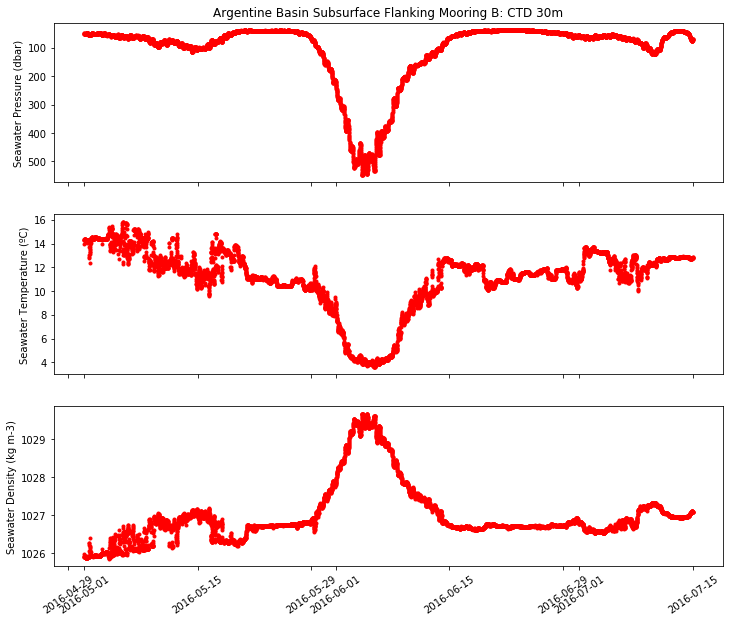

In [22]:
# plot the CTD data
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 10))
ax1.plot(FLMB_CTD_data['time'], FLMB_CTD_data['ctdmo_seawater_pressure'], 'r.')
ax1.invert_yaxis()
ax2.plot(FLMB_CTD_data['time'], FLMB_CTD_data['ctdmo_seawater_temperature'], 'r.')
ax3.plot(FLMB_CTD_data['time'], FLMB_CTD_data['density'], 'r.')
ax1.set_title('Argentine Basin Subsurface Flanking Mooring B: CTD 30m')
ax1.set_ylabel('Seawater Pressure ({})'.format(FLMB_CTD_units['ctdmo_seawater_pressure'][0]))
ax2.set_ylabel('Seawater Temperature ({})'.format(FLMB_CTD_units['ctdmo_seawater_temperature'][0]))
ax3.set_ylabel('Seawater Density ({})'.format(FLMB_CTD_units['density'][0]))

# rotate x tick labels
plt.xticks(rotation=35);

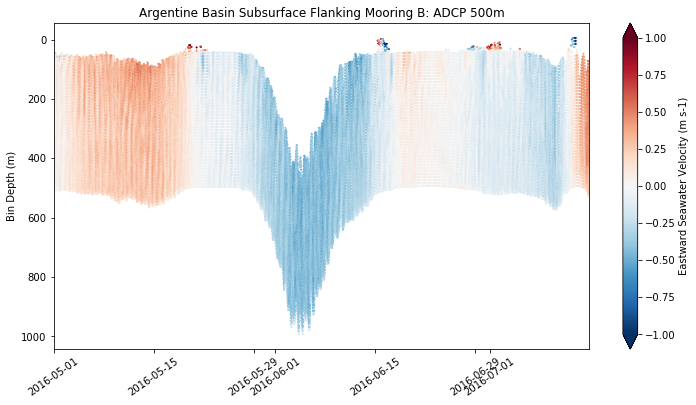

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
pcm = ax.scatter(np.array(FLMB_ADCP_data['time']), FLMB_ADCP_data['bin_depths'], 
                 c=FLMB_ADCP_data['eastward_seawater_velocity'], cmap='RdBu_r', s=1,
                 vmin=-1, vmax=1)
ax.invert_yaxis()
clabel = 'Eastward Seawater Velocity ({})'.format(FLMB_ADCP_units['eastward_seawater_velocity'][0])
bar = fig.colorbar(pcm, ax=ax, label=clabel, extend='both')
ax.set_ylabel('Bin Depth ({})'.format(FLMB_ADCP_units['bin_depths'][0]))
ax.set_title('Argentine Basin Subsurface Flanking Mooring B: ADCP 500m')

# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(FLMB_ADCP_data['time']), np.nanmax(FLMB_ADCP_data['time'])])

# rotate x tick labels
plt.xticks(rotation=35);

This mooring was also pulled down by a strong westward current, suggesting the event was widespread enough to affect both of these moorings >60km apart. Cool!

## 3. Merge and export
Now let's merge the CTD datasets and export the data as .csv files. We will export the ADCP data separately since those datasets are more complicated.

In [24]:
# rename and add units to the columns
FLMA_CTD_data = FLMA_CTD_data.rename(columns={'ctdmo_seawater_pressure': 'FLMA CTD Pressure ({})'.format(FLMA_CTD_units['ctdmo_seawater_pressure'][0]),
                                              'ctdmo_seawater_temperature': 'FLMA CTD Temp (deg_C)',
                                              'density': 'FLMA CTD Density ({})'.format(FLMA_CTD_units['density'][0])})

FLMB_CTD_data = FLMB_CTD_data.rename(columns={'ctdmo_seawater_pressure': 'FLMB CTD Pressure ({})'.format(FLMB_CTD_units['ctdmo_seawater_pressure'][0]),
                                              'ctdmo_seawater_temperature': 'FLMB CTD Temp (deg_C)',
                                              'density': 'FLMB CTD Density ({})'.format(FLMB_CTD_units['density'][0])})


In [25]:
# merge the dataframes
merged = pd.merge(FLMA_CTD_data, FLMB_CTD_data, on='time', how='outer')
merged = merged.sort_values('time').reset_index(drop=True)  # make sure the dataframe is sorted by time

# round data to 2 decimal places
merged = merged.round(2)
merged.head()

,time,FLMA CTD Pressure (dbar),FLMA CTD Temp (deg_C),FLMA CTD Density (kg m-3),FLMB CTD Pressure (dbar),FLMB CTD Temp (deg_C),FLMB CTD Density (kg m-3)
0,2016-05-01 00:00:01,49.36,13.99,1025.94,49.58,13.97,1025.98
1,2016-05-01 00:15:01,49.61,13.99,1025.94,49.76,14.30,1025.91
2,2016-05-01 00:30:01,49.86,13.99,1025.93,50.32,14.34,1025.90
3,2016-05-01 00:45:01,49.68,13.99,1025.93,51.03,14.34,1025.91
4,2016-05-01 01:00:01,49.35,13.99,1025.93,51.56,14.33,1025.92


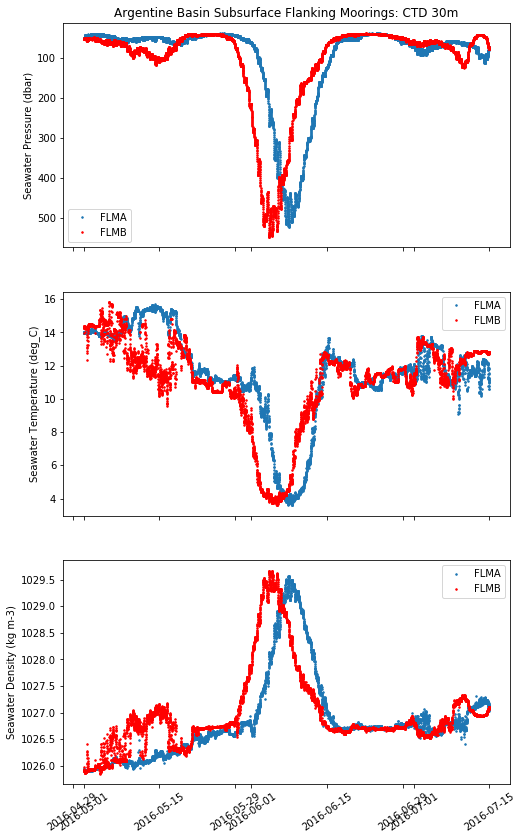

In [26]:
# plot the data again
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize = (8,14))
ax1.plot(merged['time'], merged['FLMA CTD Pressure (dbar)'], '.', markersize=3, label='FLMA')
ax1.plot(merged['time'], merged['FLMB CTD Pressure (dbar)'], 'r.', markersize=3, label='FLMB')
ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel('')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax1.set_title('Argentine Basin Subsurface Flanking Moorings: CTD 30m')

ax2.plot(merged['time'], merged['FLMA CTD Temp (deg_C)'], '.', markersize=3, label='FLMA')
ax2.plot(merged['time'], merged['FLMB CTD Temp (deg_C)'], 'r.', markersize=3, label='FLMB')
ax2.legend()
ax2.set_xlabel('')
ax2.set_ylabel('Seawater Temperature (deg_C)')

ax3.plot(merged['time'], merged['FLMA CTD Density (kg m-3)'], '.', markersize=3, label='FLMA')
ax3.plot(merged['time'], merged['FLMB CTD Density (kg m-3)'], 'r.', markersize=3, label='FLMB')
ax3.legend()
ax3.set_xlabel('')
ax3.set_ylabel('Seawater Density (kg m-3)')

# rotate x tick labels
plt.xticks(rotation=35);

In [27]:
# export the CTD data to .csv
merged.to_csv(os.path.join(save_dir, 'E02_Argentine_Basin_CTDs.csv'), index=False)

In [28]:
# drop the percent_bad_beams column
FLMA_ADCP_data = FLMA_ADCP_data.drop(columns=['percent_bad_beams'])
FLMB_ADCP_data = FLMB_ADCP_data.drop(columns=['percent_bad_beams'])

# rename and add units to the columns
FLMA_ADCP_data = FLMA_ADCP_data.rename(columns={'bin_depths': 'Bin Depths ({})'.format(FLMA_ADCP_units['bin_depths'][0]),
                                                'eastward_seawater_velocity': 'Eastward Seawater Velocity ({})'.format(FLMA_ADCP_units['eastward_seawater_velocity'][0])})
FLMB_ADCP_data = FLMB_ADCP_data.rename(columns={'bin_depths': 'Bin Depths ({})'.format(FLMB_ADCP_units['bin_depths'][0]),
                                                'eastward_seawater_velocity': 'Eastward Seawater Velocity ({})'.format(FLMB_ADCP_units['eastward_seawater_velocity'][0])})
# round data to 2 decimal places
FLMA_ADCP_data = FLMA_ADCP_data.round(2)
FLMB_ADCP_data = FLMB_ADCP_data.round(2)

FLMA_ADCP_data.head()

,time,Bin Depths (m),Eastward Seawater Velocity (m s-1)
97726,2016-05-01,42.83,-0.23
97725,2016-05-01,52.83,-0.28
97724,2016-05-01,62.83,-0.28
97723,2016-05-01,72.83,-0.23
97722,2016-05-01,82.83,-0.18


In [29]:
# export the ADCP data to .csv
FLMA_ADCP_data.to_csv(os.path.join(save_dir, 'E02_Argentine_Basin_FLMA_ADCP.csv'), index=False)
FLMB_ADCP_data.to_csv(os.path.join(save_dir, 'E02_Argentine_Basin_FLMB_ADCP.csv'), index=False)